# Loading Dataset Splits and CLAHE Transformations

We load the train and test splits from the previous experiment to maintain consistency. Additionally, we retrieve the precomputed CLAHE transformations, ensuring the same enhanced images are used for inference and further training.

In [ ]:
import pandas as pd

# Paths to dataset split files
dataset_csv_path = "/content/drive/MyDrive/FracAtlas/FracAtlas/images/dataset.csv"
train_split_path = "/content/drive/MyDrive/FracAtlas/splits/train_split.csv"
test_split_path = "/content/drive/MyDrive/FracAtlas/splits/test_split.csv"

# Load dataset CSV (contains the original image paths for train/test)
df_train_split = pd.read_csv(train_split_path)
df_test_split = pd.read_csv(test_split_path)

print("✅ Train Split Loaded:\n", df_train_split.head())
print("✅ Test Split Loaded:\n", df_test_split.head())

✅ Train Split Loaded:
                                           image_path
0  /content/drive/MyDrive/FracAtlas/FracAtlas/ima...
1  /content/drive/MyDrive/FracAtlas/FracAtlas/ima...
2  /content/drive/MyDrive/FracAtlas/FracAtlas/ima...
3  /content/drive/MyDrive/FracAtlas/FracAtlas/ima...
4  /content/drive/MyDrive/FracAtlas/FracAtlas/ima...
✅ Test Split Loaded:
                                           image_path
0  /content/drive/MyDrive/FracAtlas/FracAtlas/ima...
1  /content/drive/MyDrive/FracAtlas/FracAtlas/ima...
2  /content/drive/MyDrive/FracAtlas/FracAtlas/ima...
3  /content/drive/MyDrive/FracAtlas/FracAtlas/ima...
4  /content/drive/MyDrive/FracAtlas/FracAtlas/ima...


In [ ]:
# Path to precomputed CLAHE transformation file
clahe_transform_path = "/content/drive/MyDrive/FracAtlas/splits/clahe_transformations.csv"

# Load the CLAHE transformations file (contains exact image paths)
df_clahe = pd.read_csv(clahe_transform_path)

print(f"✅ Loaded CLAHE transformations from {clahe_transform_path}")

✅ Loaded CLAHE transformations from /content/drive/MyDrive/FracAtlas/splits/clahe_transformations.csv


# Loading Precomputed CLAHE-Enhanced Dataset

We define a dataset class that directly loads precomputed CLAHE-transformed images, avoiding redundant transformations. The dataset ensures consistency with previous training while applying only resizing, normalization, and tensor conversion. Corrupted images are handled gracefully by skipping them. DataLoaders are created for efficient batch processing.

In [ ]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import torchvision.transforms as transforms
from PIL import Image, UnidentifiedImageError
import warnings
from torch.utils.data import DataLoader

# Path to precomputed CLAHE transformation file
clahe_transform_path = "/content/drive/MyDrive/FracAtlas/splits/clahe_transformations.csv"

# Load the CLAHE transformations file (contains exact image paths)
df_clahe = pd.read_csv(clahe_transform_path)

print(f"✅ Loaded CLAHE transformations from {clahe_transform_path}")

# Define the dataset class using precomputed CLAHE transformations
class FractureDatasetWithPrecomputedCLAHE(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)  # Load image paths (with CLAHE applied)

        # Define the same transformations as before
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize first
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx, 0]  # Get the exact transformed image path

        try:
            # Load precomputed CLAHE image (it was already transformed)
            image = Image.open(image_path).convert("RGB")
            image = self.transform(image)  # Apply normalization & tensor conversion

            # Assign label
            label = 1 if "Fractured" in image_path else 0
            return image, torch.tensor(label, dtype=torch.long)

        except (OSError, UnidentifiedImageError) as e:
            #warnings.warn(f"⚠️ Skipping corrupted image: {image_path} - {e}")
            return self.__getitem__((idx + 1) % len(self.data))  # Try next valid image

print("✅ Dataset now correctly loads precomputed CLAHE transformations without reapplying them.")

✅ Loaded CLAHE transformations from /content/drive/MyDrive/FracAtlas/splits/clahe_transformations.csv
✅ Dataset now correctly loads precomputed CLAHE transformations without reapplying them.


In [ ]:
# Create dataset instances
train_dataset = FractureDatasetWithPrecomputedCLAHE(train_split_path)
test_dataset = FractureDatasetWithPrecomputedCLAHE(test_split_path)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

print("✅ DataLoader created using CLAHE transformations!")

✅ DataLoader created using CLAHE transformations!


# Loading and Fine-Tuning the Best Model (CLAHE-Enhanced EfficientNet)

We load the previously trained EfficientNet model (CLAHE variant) and fine-tune it using the same dataset. The training function is enhanced with:

Cross-entropy loss for classification.
Learning rate scheduling (ReduceLROnPlateau) to dynamically adjust the learning rate based on validation loss.
Additional evaluation metrics: Precision and Recall, alongside Accuracy and F1-score, for a more comprehensive performance assessment.
This setup ensures optimal model refinement while leveraging the best-performing transformation.

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path to the previously trained CLAHE model
model_path = "/content/drive/MyDrive/FracAtlas/models/efficientnet_clahe_lr0.0001_final.pth"

# Define the model architecture
model = models.efficientnet_b0(pretrained=False)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the training function
def train_model(model, optimizer, train_loader, test_loader, num_epochs):
    criterion = nn.CrossEntropyLoss()
    history = []

    # ✅ Initialize Learning Rate Scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        all_preds, all_labels = [], []

        # Progress bar for training
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=True)

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update tqdm description with live loss value
            progress_bar.set_postfix(loss=loss.item())

        # Compute training metrics
        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(all_labels, all_preds)
        train_f1 = f1_score(all_labels, all_preds, average="weighted")
        train_precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
        train_recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        all_val_preds, all_val_labels = [], []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(test_loader)
        val_acc = accuracy_score(all_val_labels, all_val_preds)
        val_f1 = f1_score(all_val_labels, all_val_preds, average="weighted")
        val_precision = precision_score(all_val_labels, all_val_preds, average="weighted", zero_division=0)
        val_recall = recall_score(all_val_labels, all_val_preds, average="weighted", zero_division=0)

        # Save training history
        history.append([
            epoch, train_loss, train_acc, train_f1, train_precision, train_recall,
            val_loss, val_acc, val_f1, val_precision, val_recall
        ])

        # Print progress
        print(f"Epoch {epoch}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f} | Train Precision: {train_precision:.4f} | Train Recall: {train_recall:.4f}")
        print(f"                  | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Val Precision: {val_precision:.4f} | Val Recall: {val_recall:.4f}")

        # ✅ Adjust learning rate based on validation loss
        scheduler.step(val_loss)

    return history

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-6-73921a8d30ca>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

In [ ]:
# Train EfficientNet again with the CLAHE transformations
train_model(model, optimizer, train_loader, test_loader, 50)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/50: 100%|██████████| 142/142 [08:35<00:00,  3.63s/it, loss=0.364]


Epoch 1/50 | Train Loss: 0.1023 | Train Acc: 0.9566 | Train F1: 0.9566 | Train Precision: 0.9566 | Train Recall: 0.9566
                  | Val Loss: 0.9288 | Val Acc: 0.8049 | Val F1: 0.8049 | Val Precision: 0.8052 | Val Recall: 0.8049


Epoch 2/50: 100%|██████████| 142/142 [00:22<00:00,  6.38it/s, loss=0.0641]


Epoch 2/50 | Train Loss: 0.0562 | Train Acc: 0.9832 | Train F1: 0.9832 | Train Precision: 0.9832 | Train Recall: 0.9832
                  | Val Loss: 0.8141 | Val Acc: 0.8118 | Val F1: 0.8119 | Val Precision: 0.8122 | Val Recall: 0.8118


Epoch 3/50: 100%|██████████| 142/142 [00:21<00:00,  6.52it/s, loss=0.12]


Epoch 3/50 | Train Loss: 0.0506 | Train Acc: 0.9841 | Train F1: 0.9841 | Train Precision: 0.9842 | Train Recall: 0.9841
                  | Val Loss: 0.9742 | Val Acc: 0.8188 | Val F1: 0.8188 | Val Precision: 0.8195 | Val Recall: 0.8188


Epoch 4/50: 100%|██████████| 142/142 [00:21<00:00,  6.76it/s, loss=0.00707]


Epoch 4/50 | Train Loss: 0.0311 | Train Acc: 0.9911 | Train F1: 0.9911 | Train Precision: 0.9911 | Train Recall: 0.9911
                  | Val Loss: 0.9876 | Val Acc: 0.7979 | Val F1: 0.7979 | Val Precision: 0.7980 | Val Recall: 0.7979


Epoch 5/50: 100%|██████████| 142/142 [00:20<00:00,  6.76it/s, loss=0.00348]


Epoch 5/50 | Train Loss: 0.0227 | Train Acc: 0.9956 | Train F1: 0.9956 | Train Precision: 0.9956 | Train Recall: 0.9956
                  | Val Loss: 0.8715 | Val Acc: 0.8084 | Val F1: 0.8083 | Val Precision: 0.8084 | Val Recall: 0.8084


Epoch 6/50: 100%|██████████| 142/142 [00:21<00:00,  6.71it/s, loss=0.00179]


Epoch 6/50 | Train Loss: 0.0188 | Train Acc: 0.9947 | Train F1: 0.9947 | Train Precision: 0.9947 | Train Recall: 0.9947
                  | Val Loss: 0.9651 | Val Acc: 0.8014 | Val F1: 0.8014 | Val Precision: 0.8023 | Val Recall: 0.8014


Epoch 7/50: 100%|██████████| 142/142 [00:21<00:00,  6.54it/s, loss=0.00401]


Epoch 7/50 | Train Loss: 0.0065 | Train Acc: 0.9991 | Train F1: 0.9991 | Train Precision: 0.9991 | Train Recall: 0.9991
                  | Val Loss: 0.9516 | Val Acc: 0.8084 | Val F1: 0.8083 | Val Precision: 0.8098 | Val Recall: 0.8084


Epoch 8/50: 100%|██████████| 142/142 [00:21<00:00,  6.66it/s, loss=0.0033]


Epoch 8/50 | Train Loss: 0.0080 | Train Acc: 0.9982 | Train F1: 0.9982 | Train Precision: 0.9982 | Train Recall: 0.9982
                  | Val Loss: 0.9752 | Val Acc: 0.8188 | Val F1: 0.8188 | Val Precision: 0.8189 | Val Recall: 0.8188


Epoch 9/50: 100%|██████████| 142/142 [00:21<00:00,  6.71it/s, loss=0.00266]


Epoch 9/50 | Train Loss: 0.0026 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 0.9255 | Val Acc: 0.8223 | Val F1: 0.8223 | Val Precision: 0.8223 | Val Recall: 0.8223


Epoch 10/50: 100%|██████████| 142/142 [00:21<00:00,  6.75it/s, loss=0.00254]


Epoch 10/50 | Train Loss: 0.0067 | Train Acc: 0.9982 | Train F1: 0.9982 | Train Precision: 0.9982 | Train Recall: 0.9982
                  | Val Loss: 1.0112 | Val Acc: 0.8118 | Val F1: 0.8118 | Val Precision: 0.8125 | Val Recall: 0.8118


Epoch 11/50: 100%|██████████| 142/142 [00:21<00:00,  6.65it/s, loss=0.219]


Epoch 11/50 | Train Loss: 0.0055 | Train Acc: 0.9991 | Train F1: 0.9991 | Train Precision: 0.9991 | Train Recall: 0.9991
                  | Val Loss: 0.9419 | Val Acc: 0.8153 | Val F1: 0.8153 | Val Precision: 0.8155 | Val Recall: 0.8153


Epoch 12/50: 100%|██████████| 142/142 [00:21<00:00,  6.53it/s, loss=0.00395]


Epoch 12/50 | Train Loss: 0.0027 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 0.9189 | Val Acc: 0.8258 | Val F1: 0.8258 | Val Precision: 0.8259 | Val Recall: 0.8258


Epoch 13/50: 100%|██████████| 142/142 [00:22<00:00,  6.43it/s, loss=0.00341]


Epoch 13/50 | Train Loss: 0.0030 | Train Acc: 0.9991 | Train F1: 0.9991 | Train Precision: 0.9991 | Train Recall: 0.9991
                  | Val Loss: 0.9432 | Val Acc: 0.8153 | Val F1: 0.8153 | Val Precision: 0.8153 | Val Recall: 0.8153


Epoch 14/50: 100%|██████████| 142/142 [00:22<00:00,  6.18it/s, loss=0.00158]


Epoch 14/50 | Train Loss: 0.0025 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 1.0112 | Val Acc: 0.8293 | Val F1: 0.8293 | Val Precision: 0.8295 | Val Recall: 0.8293


Epoch 15/50: 100%|██████████| 142/142 [00:23<00:00,  6.02it/s, loss=0.00126]


Epoch 15/50 | Train Loss: 0.0020 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 1.0424 | Val Acc: 0.8258 | Val F1: 0.8258 | Val Precision: 0.8258 | Val Recall: 0.8258


Epoch 16/50: 100%|██████████| 142/142 [00:22<00:00,  6.38it/s, loss=0.002]


Epoch 16/50 | Train Loss: 0.0017 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 1.0235 | Val Acc: 0.8223 | Val F1: 0.8223 | Val Precision: 0.8223 | Val Recall: 0.8223


Epoch 17/50: 100%|██████████| 142/142 [00:25<00:00,  5.55it/s, loss=0.00618]


Epoch 17/50 | Train Loss: 0.0050 | Train Acc: 0.9982 | Train F1: 0.9982 | Train Precision: 0.9982 | Train Recall: 0.9982
                  | Val Loss: 0.9547 | Val Acc: 0.8258 | Val F1: 0.8258 | Val Precision: 0.8259 | Val Recall: 0.8258


Epoch 18/50: 100%|██████████| 142/142 [00:21<00:00,  6.64it/s, loss=0.00125]


Epoch 18/50 | Train Loss: 0.0020 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 0.9428 | Val Acc: 0.8188 | Val F1: 0.8188 | Val Precision: 0.8188 | Val Recall: 0.8188


Epoch 19/50: 100%|██████████| 142/142 [00:21<00:00,  6.63it/s, loss=0.00134]


Epoch 19/50 | Train Loss: 0.0014 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 0.9618 | Val Acc: 0.8153 | Val F1: 0.8153 | Val Precision: 0.8153 | Val Recall: 0.8153


Epoch 20/50: 100%|██████████| 142/142 [00:21<00:00,  6.67it/s, loss=0.00928]


Epoch 20/50 | Train Loss: 0.0015 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 0.9517 | Val Acc: 0.8188 | Val F1: 0.8188 | Val Precision: 0.8195 | Val Recall: 0.8188


Epoch 21/50: 100%|██████████| 142/142 [00:21<00:00,  6.60it/s, loss=0.00165]


Epoch 21/50 | Train Loss: 0.0015 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 0.9786 | Val Acc: 0.8188 | Val F1: 0.8188 | Val Precision: 0.8195 | Val Recall: 0.8188


Epoch 22/50: 100%|██████████| 142/142 [00:21<00:00,  6.55it/s, loss=0.000853]


Epoch 22/50 | Train Loss: 0.0016 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 0.9365 | Val Acc: 0.8188 | Val F1: 0.8188 | Val Precision: 0.8195 | Val Recall: 0.8188


Epoch 23/50: 100%|██████████| 142/142 [00:21<00:00,  6.60it/s, loss=0.000753]


Epoch 23/50 | Train Loss: 0.0010 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 0.9322 | Val Acc: 0.8153 | Val F1: 0.8153 | Val Precision: 0.8162 | Val Recall: 0.8153


Epoch 24/50: 100%|██████████| 142/142 [00:29<00:00,  4.77it/s, loss=0.00395]


Epoch 24/50 | Train Loss: 0.0046 | Train Acc: 0.9982 | Train F1: 0.9982 | Train Precision: 0.9982 | Train Recall: 0.9982
                  | Val Loss: 0.9451 | Val Acc: 0.8188 | Val F1: 0.8188 | Val Precision: 0.8195 | Val Recall: 0.8188


Epoch 25/50: 100%|██████████| 142/142 [00:23<00:00,  6.14it/s, loss=0.104]


Epoch 25/50 | Train Loss: 0.0020 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 0.9686 | Val Acc: 0.8223 | Val F1: 0.8223 | Val Precision: 0.8228 | Val Recall: 0.8223


Epoch 26/50: 100%|██████████| 142/142 [00:22<00:00,  6.20it/s, loss=0.000731]


Epoch 26/50 | Train Loss: 0.0012 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 0.9202 | Val Acc: 0.8258 | Val F1: 0.8258 | Val Precision: 0.8261 | Val Recall: 0.8258


Epoch 27/50: 100%|██████████| 142/142 [00:24<00:00,  5.90it/s, loss=0.0011]


Epoch 27/50 | Train Loss: 0.0028 | Train Acc: 0.9991 | Train F1: 0.9991 | Train Precision: 0.9991 | Train Recall: 0.9991
                  | Val Loss: 0.9350 | Val Acc: 0.8223 | Val F1: 0.8223 | Val Precision: 0.8228 | Val Recall: 0.8223


Epoch 28/50: 100%|██████████| 142/142 [00:28<00:00,  5.05it/s, loss=0.00586]


Epoch 28/50 | Train Loss: 0.0014 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 0.9369 | Val Acc: 0.8258 | Val F1: 0.8258 | Val Precision: 0.8261 | Val Recall: 0.8258


Epoch 29/50: 100%|██████████| 142/142 [00:27<00:00,  5.11it/s, loss=0.00212]


Epoch 29/50 | Train Loss: 0.0012 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 0.9736 | Val Acc: 0.8153 | Val F1: 0.8153 | Val Precision: 0.8162 | Val Recall: 0.8153


Epoch 30/50: 100%|██████████| 142/142 [00:22<00:00,  6.21it/s, loss=0.000692]


Epoch 30/50 | Train Loss: 0.0010 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 0.9466 | Val Acc: 0.8223 | Val F1: 0.8223 | Val Precision: 0.8228 | Val Recall: 0.8223


Epoch 31/50: 100%|██████████| 142/142 [00:22<00:00,  6.27it/s, loss=0.00252]


Epoch 31/50 | Train Loss: 0.0012 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 0.9536 | Val Acc: 0.8223 | Val F1: 0.8223 | Val Precision: 0.8228 | Val Recall: 0.8223


Epoch 32/50: 100%|██████████| 142/142 [00:23<00:00,  6.12it/s, loss=0.00329]


Epoch 32/50 | Train Loss: 0.0009 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 0.9367 | Val Acc: 0.8153 | Val F1: 0.8153 | Val Precision: 0.8162 | Val Recall: 0.8153


Epoch 33/50: 100%|██████████| 142/142 [00:22<00:00,  6.18it/s, loss=0.0011]


Epoch 33/50 | Train Loss: 0.0023 | Train Acc: 0.9991 | Train F1: 0.9991 | Train Precision: 0.9991 | Train Recall: 0.9991
                  | Val Loss: 0.9697 | Val Acc: 0.8223 | Val F1: 0.8223 | Val Precision: 0.8228 | Val Recall: 0.8223


Epoch 34/50: 100%|██████████| 142/142 [00:22<00:00,  6.41it/s, loss=0.00167]


Epoch 34/50 | Train Loss: 0.0009 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 0.9503 | Val Acc: 0.8223 | Val F1: 0.8223 | Val Precision: 0.8228 | Val Recall: 0.8223


Epoch 35/50: 100%|██████████| 142/142 [00:22<00:00,  6.43it/s, loss=0.00134]


Epoch 35/50 | Train Loss: 0.0012 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 0.9349 | Val Acc: 0.8188 | Val F1: 0.8188 | Val Precision: 0.8195 | Val Recall: 0.8188


Epoch 36/50: 100%|██████████| 142/142 [00:21<00:00,  6.48it/s, loss=0.00277]


Epoch 36/50 | Train Loss: 0.0039 | Train Acc: 0.9991 | Train F1: 0.9991 | Train Precision: 0.9991 | Train Recall: 0.9991
                  | Val Loss: 0.9369 | Val Acc: 0.8118 | Val F1: 0.8118 | Val Precision: 0.8130 | Val Recall: 0.8118


Epoch 37/50: 100%|██████████| 142/142 [00:20<00:00,  6.83it/s, loss=0.000579]


Epoch 37/50 | Train Loss: 0.0019 | Train Acc: 0.9991 | Train F1: 0.9991 | Train Precision: 0.9991 | Train Recall: 0.9991
                  | Val Loss: 0.9305 | Val Acc: 0.8188 | Val F1: 0.8188 | Val Precision: 0.8195 | Val Recall: 0.8188


Epoch 38/50: 100%|██████████| 142/142 [00:20<00:00,  6.80it/s, loss=0.00117]


Epoch 38/50 | Train Loss: 0.0008 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 0.9579 | Val Acc: 0.8223 | Val F1: 0.8223 | Val Precision: 0.8228 | Val Recall: 0.8223


Epoch 39/50: 100%|██████████| 142/142 [00:20<00:00,  6.83it/s, loss=0.000715]


Epoch 39/50 | Train Loss: 0.0021 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 0.9272 | Val Acc: 0.8153 | Val F1: 0.8153 | Val Precision: 0.8162 | Val Recall: 0.8153


Epoch 40/50: 100%|██████████| 142/142 [00:21<00:00,  6.70it/s, loss=0.00849]


Epoch 40/50 | Train Loss: 0.0018 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 0.9653 | Val Acc: 0.8118 | Val F1: 0.8118 | Val Precision: 0.8130 | Val Recall: 0.8118


Epoch 41/50: 100%|██████████| 142/142 [00:20<00:00,  6.77it/s, loss=0.000921]


Epoch 41/50 | Train Loss: 0.0008 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 0.9266 | Val Acc: 0.8223 | Val F1: 0.8223 | Val Precision: 0.8228 | Val Recall: 0.8223


Epoch 42/50: 100%|██████████| 142/142 [00:21<00:00,  6.59it/s, loss=0.00587]


Epoch 42/50 | Train Loss: 0.0010 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 0.9561 | Val Acc: 0.8153 | Val F1: 0.8153 | Val Precision: 0.8162 | Val Recall: 0.8153


Epoch 43/50: 100%|██████████| 142/142 [00:22<00:00,  6.34it/s, loss=0.00633]


Epoch 43/50 | Train Loss: 0.0018 | Train Acc: 0.9991 | Train F1: 0.9991 | Train Precision: 0.9991 | Train Recall: 0.9991
                  | Val Loss: 0.9427 | Val Acc: 0.8223 | Val F1: 0.8223 | Val Precision: 0.8228 | Val Recall: 0.8223


Epoch 44/50: 100%|██████████| 142/142 [00:22<00:00,  6.36it/s, loss=0.000798]


Epoch 44/50 | Train Loss: 0.0009 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 0.9494 | Val Acc: 0.8153 | Val F1: 0.8153 | Val Precision: 0.8162 | Val Recall: 0.8153


Epoch 45/50: 100%|██████████| 142/142 [00:22<00:00,  6.28it/s, loss=0.00382]


Epoch 45/50 | Train Loss: 0.0019 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 0.9500 | Val Acc: 0.8258 | Val F1: 0.8258 | Val Precision: 0.8261 | Val Recall: 0.8258


Epoch 46/50: 100%|██████████| 142/142 [00:22<00:00,  6.31it/s, loss=0.00104]


Epoch 46/50 | Train Loss: 0.0026 | Train Acc: 0.9991 | Train F1: 0.9991 | Train Precision: 0.9991 | Train Recall: 0.9991
                  | Val Loss: 0.9407 | Val Acc: 0.8258 | Val F1: 0.8258 | Val Precision: 0.8261 | Val Recall: 0.8258


Epoch 47/50: 100%|██████████| 142/142 [00:22<00:00,  6.35it/s, loss=0.00161]


Epoch 47/50 | Train Loss: 0.0008 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 0.9565 | Val Acc: 0.8153 | Val F1: 0.8153 | Val Precision: 0.8162 | Val Recall: 0.8153


Epoch 48/50: 100%|██████████| 142/142 [00:22<00:00,  6.39it/s, loss=0.00287]


Epoch 48/50 | Train Loss: 0.0011 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 0.9500 | Val Acc: 0.8258 | Val F1: 0.8258 | Val Precision: 0.8261 | Val Recall: 0.8258


Epoch 49/50: 100%|██████████| 142/142 [00:21<00:00,  6.60it/s, loss=0.00205]


Epoch 49/50 | Train Loss: 0.0010 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 0.9394 | Val Acc: 0.8153 | Val F1: 0.8153 | Val Precision: 0.8162 | Val Recall: 0.8153


Epoch 50/50: 100%|██████████| 142/142 [00:21<00:00,  6.72it/s, loss=0.00161]


Epoch 50/50 | Train Loss: 0.0015 | Train Acc: 1.0000 | Train F1: 1.0000 | Train Precision: 1.0000 | Train Recall: 1.0000
                  | Val Loss: 0.9596 | Val Acc: 0.8223 | Val F1: 0.8223 | Val Precision: 0.8228 | Val Recall: 0.8223


[[1,
  0.10229943573358469,
  0.9565987599645704,
  0.9566008031819356,
  0.9566403717798042,
  0.9565987599645704,
  0.9287682606243632,
  0.8048780487804879,
  0.8048875243997196,
  0.8052097276679421,
  0.8048780487804879],
 [2,
  0.056211887239019424,
  0.983170947741364,
  0.9831715023515628,
  0.98318594218433,
  0.983170947741364,
  0.8140902895635614,
  0.8118466898954704,
  0.8118558270997295,
  0.8121803994699908,
  0.8118466898954704],
 [3,
  0.05055263510521527,
  0.9840566873339238,
  0.9840575879729772,
  0.9841573079742636,
  0.9840566873339238,
  0.9742326532141306,
  0.818815331010453,
  0.818802132826523,
  0.8195050842636706,
  0.818815331010453],
 [4,
  0.03109395433000853,
  0.9911426040744021,
  0.9911426040744021,
  0.9911426040744021,
  0.9911426040744021,
  0.9875993088870827,
  0.7979094076655052,
  0.7979241301467341,
  0.7980163467968345,
  0.7979094076655052],
 [5,
  0.022703966099304036,
  0.995571302037201,
  0.9955713576398387,
  0.9955729756358838,
  0.

In [ ]:
model_save_path = "/content/drive/MyDrive/FracAtlas/models/efficientnet_clahe_lr0.0001_v2.pth"
torch.save(model.state_dict(), model_save_path)
print(f"✅ Model saved at: {model_save_path}")

✅ Model saved at: /content/drive/MyDrive/FracAtlas/models/efficientnet_clahe_lr0.0001_v2.pth


# Model Inference on Test Images with CLAHE

We evaluate the CLAHE-enhanced EfficientNet model on randomly selected test images. The pipeline includes:

Loading the trained model and ensuring it runs in evaluation mode.
Applying CLAHE to enhance the input images before feeding them into the model.
Predicting the fracture status and comparing it with the actual label.
Visualizing predictions, displaying both the actual and predicted labels for interpretability.
This step helps assess how well the model generalizes to unseen data while verifying the effectiveness of CLAHE preprocessing.

<ipython-input-10-5b3d6af34790>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_location=device))


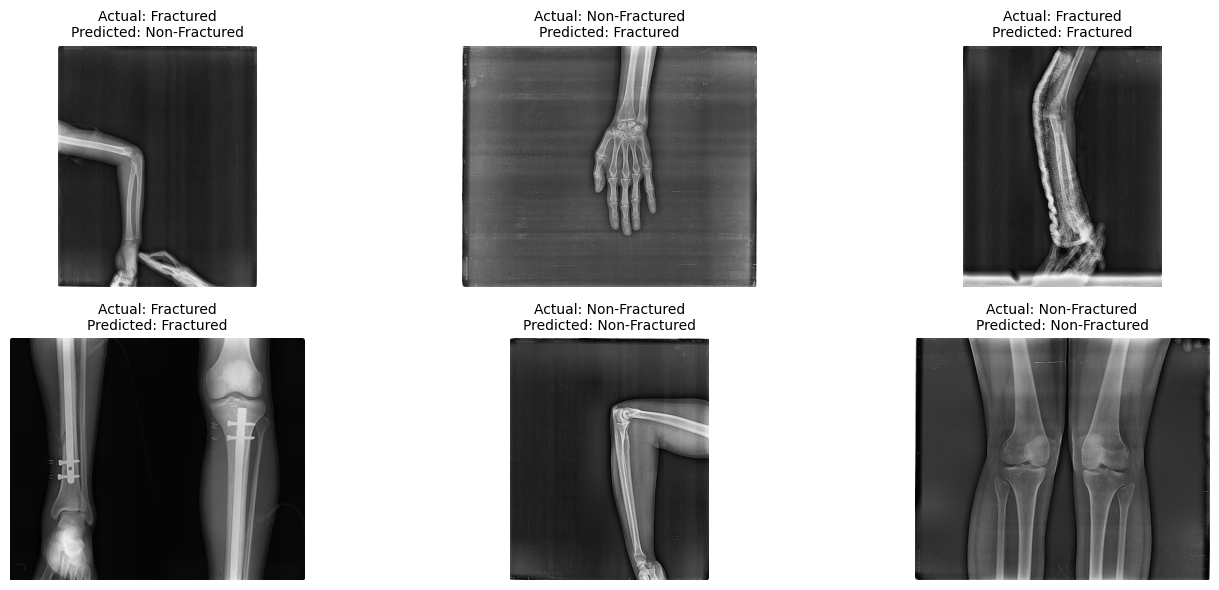

In [ ]:
import torch
import random
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
from torchvision import models
import cv2
import warnings

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load trained model
model_save_path = "/content/drive/MyDrive/FracAtlas/models/efficientnet_clahe_lr0.0001_v2.pth"
model = models.efficientnet_b0(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 2)  # Adjust classifier for binary classification
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.to(device)
model.eval()

# Define transformation (same as used in training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Function to apply CLAHE
def apply_clahe(image):
    image_np = np.array(image.convert("L"))  # Convert to grayscale
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_applied = clahe.apply(image_np)  # Apply CLAHE
    return Image.fromarray(clahe_applied).convert("RGB")  # Convert back to RGB

# Function to safely open images (skip corrupted images)
def safe_open_image(image_path):
    try:
        with Image.open(image_path) as img:
            img.load()  # Ensure full loading in memory
            return img.convert("RGB")
    except (OSError, UnidentifiedImageError) as e:
        warnings.warn(f"⚠️ Skipping corrupted image: {image_path} - {e}")
        return None  # Return None to indicate failure

# Select multiple random images from the test dataset
num_samples = 6  # Number of images to display
random_indices = random.sample(range(len(test_dataset)), num_samples)
valid_samples = []  # List to store valid images

for idx in random_indices:
    image_path = test_dataset.data.iloc[idx, 0]

    # Try to open image
    image = safe_open_image(image_path)
    if image is not None:
        valid_samples.append((image, image_path))

    # Stop once we have enough valid samples
    if len(valid_samples) == num_samples:
        break

# Prepare figure
fig, axes = plt.subplots(2, num_samples // 2, figsize=(15, 6))

label_names = ["Non-Fractured", "Fractured"]

for i, (image, image_path) in enumerate(valid_samples):
    # Get actual label from filename
    actual_label = 1 if "Fractured" in image_path else 0

    # Apply CLAHE transformation
    image_clahe = apply_clahe(image)

    # Preprocess for model
    input_tensor = transform(image_clahe).unsqueeze(0).to(device)

    # Get model prediction
    with torch.no_grad():
        output = model(input_tensor)
        predicted_label = torch.argmax(output, dim=1).item()

    # Convert labels to readable text
    actual_text = label_names[actual_label]
    predicted_text = label_names[predicted_label]

    # Display the image
    ax = axes[i // (num_samples // 2), i % (num_samples // 2)]
    ax.imshow(image_clahe)
    ax.set_title(f"Actual: {actual_text}\nPredicted: {predicted_text}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

# Saving the Trained Model to Hugging Face Hub

To make the CLAHE-enhanced EfficientNet model easily accessible, we prepare it for upload to Hugging Face:

Authenticate with Hugging Face Hub to enable model storage and sharing.
Load the trained model and ensure it matches the architecture used during training.
Save the model in Hugging Face format, making it compatible for later use and inference.
This step allows seamless model deployment and sharing for further research and experimentation.

In [ ]:
!pip install huggingface_hub

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import AutoModel

# Path to your trained model
model_path = "/content/drive/MyDrive/FracAtlas/models/efficientnet_clahe_lr0.0001_v2.pth"

# Define the model architecture (same as training)
from torchvision import models
model = models.efficientnet_b0(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 2)

# Load model weights
model.load_state_dict(torch.load(model_path, map_location="cpu"))
model.eval()

# Save it in Hugging Face format
hf_model_path = "efficientnet_clahe_hf"
torch.save(model, f"{hf_model_path}.pt")
print(f"✅ Model saved in Hugging Face format: {hf_model_path}.pt")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-16-d68db339311c>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

✅ Model saved in Hugging Face format: efficientnet_clahe_hf.pt


In [ ]:
from huggingface_hub import HfApi

# Define repository name (change it to a unique name)
repo_name = "efficientnet_clahe_fracture_classification"
username = "potguy"  # Replace with your actual HF username
repo_id = f"{username}/{repo_name}"

# Initialize API
api = HfApi()

# ✅ Create repo (ensuring it's a model repo)
api.create_repo(repo_id, repo_type="model", exist_ok=True)

print(f"✅ Repository created: https://huggingface.co/{repo_id}")

✅ Repository created: https://huggingface.co/potguy/efficientnet_clahe_fracture_classification


In [ ]:
import os

hf_model_path = "efficientnet_clahe_hf.pt"  # Ensure this matches your saved model filename
print("File exists:", os.path.exists(hf_model_path))

File exists: True


# Uploading and Downloading the Model from Hugging Face Hub

This section facilitates sharing and reusing the CLAHE-enhanced EfficientNet model by:

Uploading the full model and its state_dict (weights only) to the Hugging Face Hub.
Providing direct links to access the model repository.
Downloading the model weights from Hugging Face and reloading the architecture for inference.
This allows easy access to the model for future research, deployment, and collaboration.

In [ ]:
from huggingface_hub import HfApi

repo_id = "potguy/efficientnet_clahe_fracture_classification"  # Your HF repo

api = HfApi()
api.upload_file(
    path_or_fileobj=hf_model_path,
    path_in_repo=hf_model_path,  # This determines the filename in the repo
    repo_id=repo_id,
    repo_type="model"
)

print(f"✅ Model uploaded successfully to: https://huggingface.co/{repo_id}")

efficientnet_clahe_hf.pt:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

✅ Model uploaded successfully to: https://huggingface.co/potguy/efficientnet_clahe_fracture_classification


In [ ]:
torch.save(model.state_dict(), "efficientnet_clahe_hf.pth")  # Save only weights

from huggingface_hub import HfApi

repo_id = "potguy/efficientnet_clahe_fracture_classification"

api = HfApi()
api.upload_file(
    path_or_fileobj="efficientnet_clahe_hf.pth",
    path_in_repo="efficientnet_clahe_hf.pth",
    repo_id=repo_id,
    repo_type="model"
)

print(f"✅ Model weights uploaded to: https://huggingface.co/{repo_id}")


efficientnet_clahe_hf.pth:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

✅ Model weights uploaded to: https://huggingface.co/potguy/efficientnet_clahe_fracture_classification


In [ ]:
from huggingface_hub import hf_hub_download
import torch
from torchvision import models

repo_id = "potguy/efficientnet_clahe_fracture_classification"
filename = "efficientnet_clahe_hf.pth"

# Download model weights from Hugging Face
local_model_path = hf_hub_download(repo_id=repo_id, filename=filename)

# Load the model
model = models.efficientnet_b0(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 2)
model.load_state_dict(torch.load(local_model_path, map_location="cpu"))
model.eval()

print("✅ Model loaded successfully.")

efficientnet_clahe_hf.pth:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

✅ Model loaded successfully.


<ipython-input-28-0bd781bb7ae0>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(local_model_path, map_location="cpu"))
